<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 4. Линейные модели классификации и регрессии
## <center>Часть 4. Где логистическая регрессия хороша и где не очень

### Анализ отзывов IMDB к фильмам

Будем решать задачу бинарной классификации отзывов IMDB к фильмам. Имеется обучающая выборка с размеченными отзывами, по 12500 отзывов известно, что они хорошие, еще про 12500 – что они плохие. Здесь уже не так просто сразу приступить к машинному обучению, потому что готовой матрицы $X$ нет  – ее надо приготовить. Будем использовать самый простой подход – мешок слов ("Bag of words"). При таком подходе признаками отзыва будут индикаторы наличия в нем каждого слова из всего корпуса, где корпус – это множество всех отзывов. Идея иллюстрируется картинкой

<img src="../img/bag_of_words.svg" width=80%>

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

**Загрузим данные [отсюда](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) (это прямая ссылка на скачивание, а [вот](http://ai.stanford.edu/~amaas/data/sentiment/) описание набора данных). В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам.**

In [3]:
# поменяйте путь к файлу
reviews_train = load_files("/home/totalchest/Downloads/aclImdb/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [4]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 75000
[12500 12500 50000]


In [7]:
# поменяйте путь к файлу
reviews_test = load_files("/home/totalchest/Downloads/aclImdb/test")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


**Пример отзыва и соответствующей метки.**

In [10]:
print(text_train[1])

b"Amount of disappointment I am getting these days seeing movies like Partner, Jhoom Barabar and now, Heyy Babyy is gonna end my habit of seeing first day shows.<br /><br />The movie is an utter disappointment because it had the potential to become a laugh riot only if the d\xc3\xa9butant director, Sajid Khan hadn't tried too many things. Only saving grace in the movie were the last thirty minutes, which were seriously funny elsewhere the movie fails miserably. First half was desperately been tried to look funny but wasn't. Next 45 minutes were emotional and looked totally artificial and illogical.<br /><br />OK, when you are out for a movie like this you don't expect much logic but all the flaws tend to appear when you don't enjoy the movie and thats the case with Heyy Babyy. Acting is good but thats not enough to keep one interested.<br /><br />For the positives, you can take hot actresses, last 30 minutes, some comic scenes, good acting by the lead cast and the baby. Only problem is

In [11]:
y_train[1] # плохой отзыв

2

In [12]:
text_train[2]

b'The future, we are told, are what we make of it. Philip K. Dick did not want to take that chance, so he wrote many many many short stories about the future of man and where we, as a society, were headed. Blade Runner, Total Recall, Paycheck, Screamers, and Minority Report are all short stories written by Dick about the future that have been turned into a movie, and most have a less than enthusiastic view of where we are headed. In Minority Report, we see the effects of predicting the future to the point of crimes are prevented by arresting murderers before they kill. If that does not appear logical, there is a quick little scene early in the movie that addresses those concerns, and on the surface makes sense. Tom Cruise plays the Washington, DC pre-crime chief, John Anderton, who runs the investigators who rely on 3 scientifically engineered beings who can see murders before they happen. The system, of course, raises civil liberty issues, but seems to work perfectly, that is until An

In [13]:
y_train[2] # хороший отзыв

2

## Простой подсчет слов

**Составим словарь всех слов с помощью CountVectorizer.**

In [33]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

124255

**Посмотрим на примеры полученных "слов" (лучше их называть токенами). Видим, что многие важные этапы обработки текста мы тут пропустили.**

In [34]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000', '0000000000000000000000000000000001', '0000000000001', '000000001', '000000003', '00000001', '000001745', '00001', '0001', '00015', '0002', '0007', '00083', '000ft', '000s', '000th', '001', '002', '003', '003830', '004', '005', '006', '007', '0079', '008', '0080', '0083', '009', '0091042', '0093638', '00am', '00o', '00pm', '00s', '01', '015', '019', '01p', '01pm', '02', '020410', '022', '0267', '029', '03', '0312', '039']
['heathen', 'heathens', 'heather', 'heatherbennett', 'heatherly', 'heathers', 'heatherton', 'heathkit', 'heathrow', 'heating', 'heatman', 'heatmiser', 'heaton', 'heats', 'heatseeker', 'heatwave', 'heave', 'heaved', 'heaven', 'heavenlier', 'heavenliness', 'heavenly', 'heavens', 'heavenward', 'heaves', 'heavier', 'heavies', 'heaviest', 'heavily', 'heaviness', 'heaving', 'heavy', 'heavyarms', 'heavyhanded', 'heavys', 'heavyset', 'heavyweight', 'heavyweights', 'heber', 'hebert', 'hebetude', 'hebner', 'hebraic', 'hebrew', 'hebrews', 'hebrides', 'hebro

**Закодируем предложения из текстов обучающей выборки индексами входящих слов. Используем разреженный формат.**

In [35]:
X_train = cv.transform(text_train)
X_train

<75000x124255 sparse matrix of type '<class 'numpy.int64'>'
	with 10359806 stored elements in Compressed Sparse Row format>

**Посмотрим, как преобразование подействовало на одно из предложений.**

In [36]:
print(text_train[19726])

b'When celebrating the cycle-of-life "Cabaret" sits on the spice shelf.<br /><br />A town which is occupied by a sausage-factory which comes to life when the meat-plant workers come in for rest and relaxation and perform the lessons and morality-tales which are learned from safe and unsafe handling of food and objects around different life-forms.<br /><br />That sex, love, and family must sometimes be sacrificed to perform and follow the foot-lights of the stage.<br /><br />War is sometimes a bi-product of military-personal racing to their favourite performance venue(s) where "other" children and wives lived and worked in Europe and especially in Germany.<br /><br />The cycle-of-life is the call for many to chase the memory and contact with those people and places which made them excel at something, namely war.<br /><br />That in the end the only way to keep some of the universe\'s life-forms from racing to a celebration of war as depicted in other films such as "Wood Stock" and "Schin

In [37]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([  5618,   7054,   7369,   7611,   8095,  10438,  10846,  12304,
         14846,  16930,  17043,  17335,  19129,  19130,  19874,  20445,
         22862,  22895,  24215,  24427,  26983,  29377,  29850,  30506,
         30509,  35168,  35960,  36083,  37034,  37373,  37740,  38685,
         38949,  39465,  40411,  41637,  41697,  41728,  41777,  42019,
         42941,  44847,  48974,  54396,  56764,  59788,  63251,  63841,
         64209,  64299,  64681,  64804,  65659,  66706,  67864,  69694,
         70191,  71254,  71442,  72560,  73037,  73563,  74308,  74845,
 

In [38]:
X_train[19726].nonzero()[1]

array([  5618,   7054,   7369,   7611,   8095,  10438,  10846,  12304,
        14846,  16930,  17043,  17335,  19129,  19130,  19874,  20445,
        22862,  22895,  24215,  24427,  26983,  29377,  29850,  30506,
        30509,  35168,  35960,  36083,  37034,  37373,  37740,  38685,
        38949,  39465,  40411,  41637,  41697,  41728,  41777,  42019,
        42941,  44847,  48974,  54396,  56764,  59788,  63251,  63841,
        64209,  64299,  64681,  64804,  65659,  66706,  67864,  69694,
        70191,  71254,  71442,  72560,  73037,  73563,  74308,  74845,
        77646,  77840,  78010,  78458,  78529,  79267,  79272,  82072,
        82219,  82223,  82444,  83765,  83852,  86367,  88401,  90774,
        91678,  94532,  94621,  95632,  96154,  98076,  98732, 100389,
       102253, 102284, 102290, 102977, 103177, 103986, 104950, 106183,
       108285, 109890, 109916, 109969, 109985, 110367, 111180, 111939,
       115549, 116025, 117589, 119400, 119561, 119773, 120484, 120491,
      

**Преобразуем так же тестовую выборку.**

In [39]:
X_test = cv.transform(text_test)

**Обучим логистическую регрессию.**

In [40]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

CPU times: user 109 ms, sys: 256 ms, total: 365 ms
Wall time: 25 s


LogisticRegression(n_jobs=-1, random_state=7)

**Посмотрим на доли правильных ответов на обучающей и тестовой выборках.**

In [41]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3),

(0.723, 0.132)

**Коэффициенты модели можно красиво отобразить.**

In [42]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");


In [43]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();
    

IndexError: index 246283 is out of bounds for axis 0 with size 124255

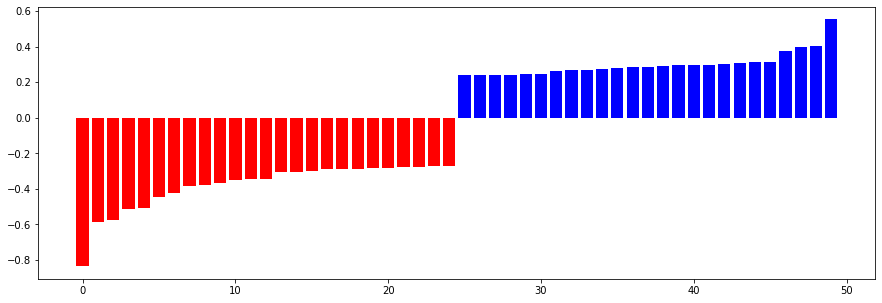

In [44]:
visualize_coefficients(logit, cv.get_feature_names())

**Подберем коэффициент регуляризации для логистической регрессии. Используем `sklearn.pipeline`, поскольку `CountVectorizer` правильно применять только на тех данных, на которых в текущий момент обучается модель (чтоб не "подсматривать" в тестовую выборку и не считать по ней частоты вхождения слов). В данном случае `pipeline` задает последовательность действий: применить `CountVectorizer`, затем обучить логистическую регрессию.**

In [45]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(), 
                                LogisticRegression(n_jobs=-1, random_state=7))

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

0.1324
CPU times: user 12.3 s, sys: 236 ms, total: 12.5 s
Wall time: 33.7 s


In [46]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1)

grid_logit.fit(text_train, y_train)

CPU times: user 10.7 s, sys: 2.1 s, total: 12.8 s
Wall time: 4min 12s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=7))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])})

**Лучшее значение C и соответствующее качество на кросс-валидации:**

In [47]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.01}, 0.6769066666666667)

In [48]:
plot_grid_scores(grid_logit, 'logisticregression__C')

KeyError: 'mean_train_score'

На валидационной выборке:

In [49]:
grid_logit.score(text_test, y_test)

0.11496

**Теперь то же самое, но со случайным лесом. Видим, что с логистической регрессией мы достигаем большей доли правильных ответов меньшими усилиями**

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
forest = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)

In [52]:
%%time
forest.fit(X_train, y_train)

CPU times: user 1h 29min 44s, sys: 13.2 s, total: 1h 29min 57s
Wall time: 12min 34s


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)

In [53]:
round(forest.score(X_test, y_test), 3)

0.005

### XOR-проблема
Теперь рассмотрим пример, где линейные модели справляются хуже. 

Линейные методы классификации строят все же очень простую разделяющую поверхность – гиперплоскость. Самый известный игрушечный пример, в котором классы нельзя без ошибок поделить гиперплоскостью (то есть прямой, если это 2D), получил имя "the XOR problem".

XOR – это "исключающее ИЛИ", булева функция со следующей таблицей истинности:

<img src='../img/XOR_table.gif'>

XOR дал имя простой задаче бинарной классификации, в которой классы представлены вытянутыми по диагоналям и пересекающимися облаками точек. 

In [55]:
# порождаем данные
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

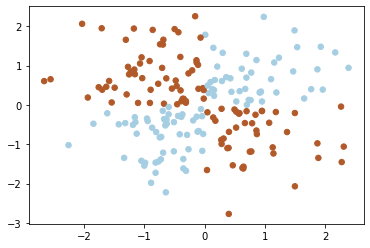

In [56]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

Очевидно, нельзя провести прямую так, чтобы без ошибок отделить один класс от другого. Поэтому логистическая регрессия плохо справляется с такой задачей. 

In [57]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

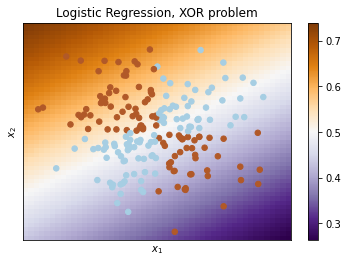

In [58]:
plot_boundary(LogisticRegression(), X, y,
              "Logistic Regression, XOR problem")

А вот если на вход подать полиномиальные признаки, в данном случае до 2 степени, то проблема решается. 

In [60]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [67]:
logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', LogisticRegression())])

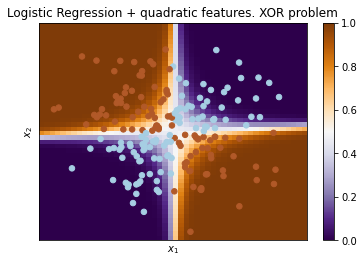

In [68]:
plot_boundary(logit_pipe, X, y,
              "Logistic Regression + quadratic features. XOR problem")

Здесь логистическая регрессия все равно строила гиперплоскость, но в 6-мерном пространстве признаков $1, x_1, x_2, x_1^2, x_1x_2$ и $x_2^2$. В проекции на исходное пространство признаков $x_1, x_2$ граница получилась нелинейной. 

На практике полиномиальные признаки действительно помогают, но строить их явно – вычислительно неэффективно. Гораздо быстрее работает SVM с ядровым трюком. При таком подходе в пространстве высокой размерности считается только расстояние между объектами (задаваемое функцией-ядром), а явно плодить комбинаторно большое число признаков не приходится. Про это подробно можно почитать в курсе Евгения Соколова – [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem10_linear.pdf) (математика уже серьезная).